# Make artificial NA-based dataset for ANN training

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model
import sys

from disp import set_plot
from my_torch import skl_fit_ridge

cc = np.concatenate


TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

PFX_BHV = f'data/simple/behav_xtd/behav_xtd'

NNRN = 224
NRL_MDL = 'ma'

PTRAIN = .8
NSPLIT = 30

ALPHA = 10

NSPLIT_SAVE_Y_HAT = 5

MASK_PFX = 'data/simple/masks/mask'

if MASK_PFX:
    FSAVE_SFX = f'{TARG_BHV.lower()}_ridge_alpha_{ALPHA}_masked'
else:
    FSAVE_SFX = f'{TARG_BHV.lower()}_ridge_alpha_{ALPHA}'

In [2]:
# SPECIFY STRAINS USED
STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = len(ISTRAIN)
NTRAIN = int(round(PTRAIN*NTR))

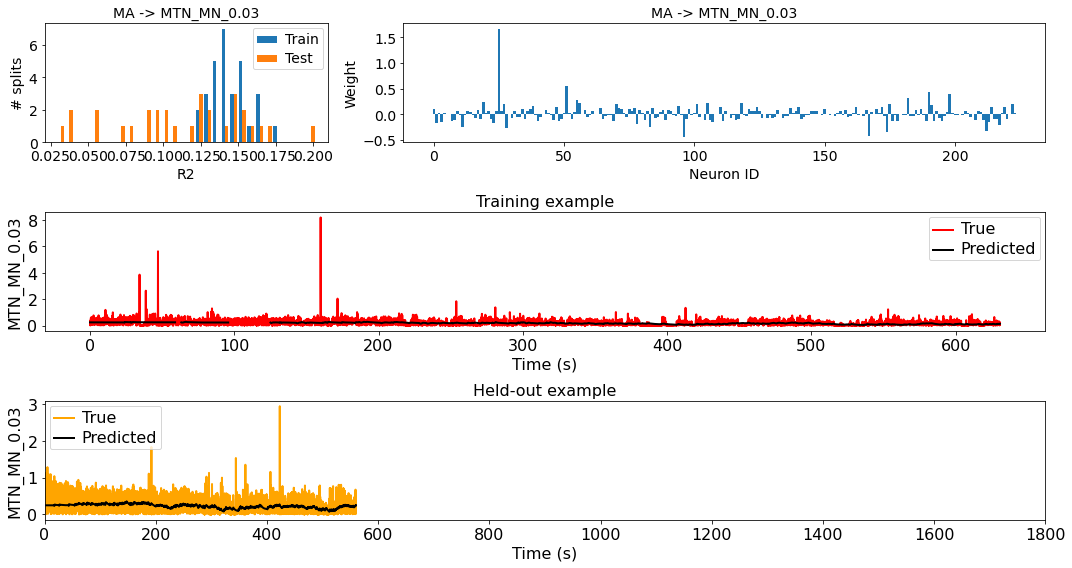

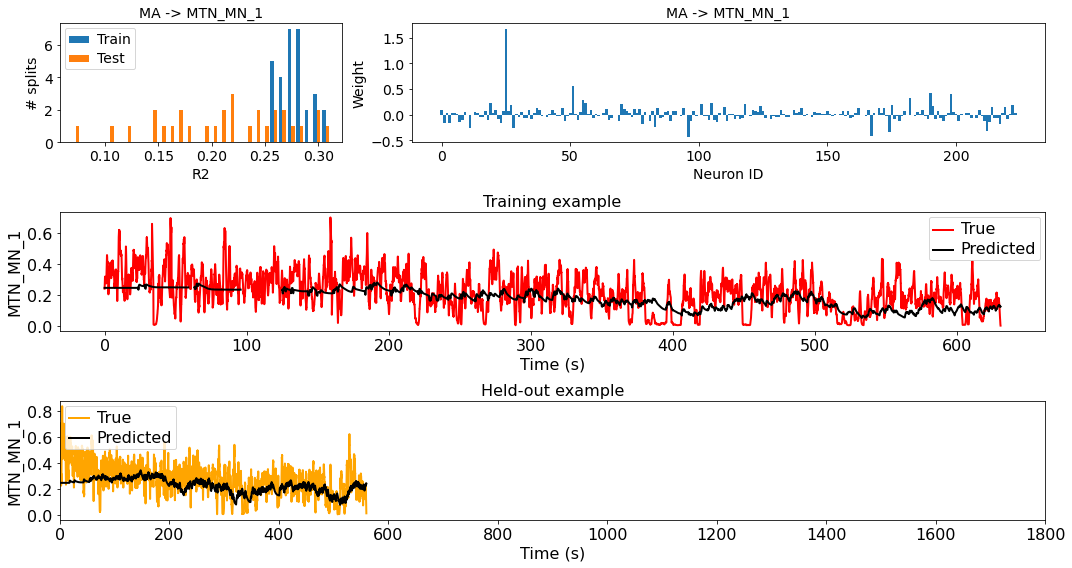

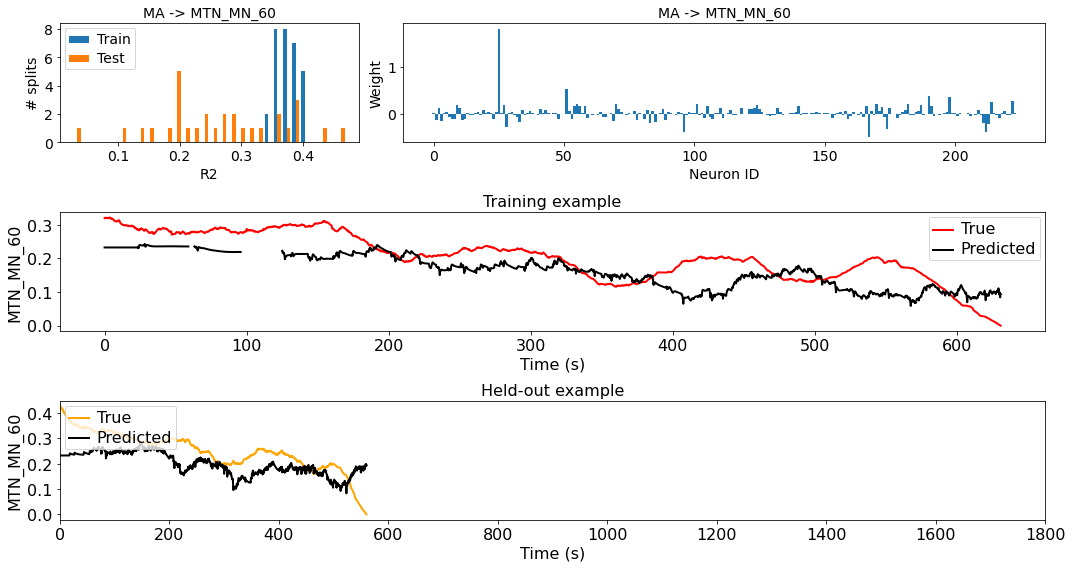

In [3]:
ISPLIT = 0
ITRAIN_PLOT = 1
ITEST_PLOT = 1

FPS = 30.03

fsave = f'data/simple/mlv/neur_basic/baker_{NRL_MDL}_{STRAIN_KEY}_{TARG_BHV.lower()}_ridge_alpha_{ALPHA}_masked.npy'
data = np.load(fsave, allow_pickle=True)[0]

w_mns = []
bias_mns = []

for targ in TARGS:

    r2_train = data['r2_train'][targ]
    r2_test = data['r2_test'][targ]

    gs = gridspec.GridSpec(3, 3)

    fig = plt.figure(figsize=(15, 8), tight_layout=True)
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1:]), fig.add_subplot(gs[1, :]), fig.add_subplot(gs[2, :])]

    axs[0].hist(np.transpose([r2_train, r2_test]), bins=30)
    axs[0].legend(['Train', 'Test'])

    set_plot(axs[0], x_label='R2', y_label='# splits', title=f'{NRL_MDL.upper()} -> {targ}', font_size=14)

    axs[1].bar(np.arange(data['w'][targ].shape[1]), np.mean(data['w'][targ], axis=0), width=1)
    set_plot(axs[1], x_label='Neuron ID', y_label='Weight', title=f'{NRL_MDL.upper()} -> {targ}', font_size=14)
    
    w_mns.append(np.mean(data['w'][targ], axis=0))
    bias_mns.append(np.mean(data['bias'][targ], axis=0))

    y_train = data['ys_train'][targ][ISPLIT][ITRAIN_PLOT]
    t_train = np.arange(len(y_train))/FPS

    y_hat_train = data['y_hats_train'][targ][ISPLIT][ITRAIN_PLOT]

    axs[2].plot(t_train, y_train, c='r', lw=2)
    axs[2].plot(t_train, y_hat_train, c='k', lw=2)

    axs[2].legend(['True', 'Predicted'])

    set_plot(axs[2], x_label='Time (s)', y_label=targ, title='Training example', font_size=16)

    y_test = data['ys_test'][targ][ISPLIT][ITEST_PLOT]
    t_test = np.arange(len(y_test))/FPS

    y_hat_test = data['y_hats_test'][targ][ISPLIT][ITEST_PLOT]

    axs[3].plot(t_test, y_test, c='orange', lw=2)
    axs[3].plot(t_test, y_hat_test, c='k', lw=2)

    axs[3].legend(['True', 'Predicted'], loc='upper left')

    set_plot(axs[3], x_lim=(0, 1800), x_label='Time (s)', y_label=targ, title='Held-out example', font_size=16)

# Load artificial recordings and generate female motion predictions

In [4]:
LOAD_DIR = 'data/simple/mlv/neur_basic/baker_ma'
NTR = 276
RCOLS = [f'R_{cnrn}' for cnrn in range(NNRN)]

In [5]:
import os
import sys

df_tr_mas = []

for ctr in range(NTR):
    
    sys.stdout.write('.')
    
    df_tr = np.load(os.path.join(LOAD_DIR, f'mlv_baker_ma_tr_{ctr}.npy'), allow_pickle=True)[0]['df']
    
    i_s = np.array((df_tr['S']==1), dtype=float)
    i_p = np.array((df_tr['P']==1)|(df_tr['F']==1), dtype=float)
    
    data_tr = {'ID': np.array(df_tr['ID']), 'FRAME': df_tr['FRAME'], 'T': np.array(df_tr['T']), 'S': i_s, 'P': i_p}
    
    rs = np.array(df_tr[RCOLS])
    
    for targ, w_mn, bias_mn in zip(TARGS, w_mns, bias_mns):
        data_tr[targ] = rs@w_mn + bias_mn
        
    df_tr_ma = pd.DataFrame(columns=(['ID', 'FRAME', 'T', 'S', 'P'] + TARGS), data=data_tr)
    df_tr_mas.append(df_tr_ma)

....................................................................................................................................................................................................................................................................................

In [6]:
df_full_ma = pd.concat(df_tr_mas)
df_full_ma.to_csv('data/simple/ann/c_song_f_behav_ma.csv', index=False)

In [7]:
df_behav_ma = pd.read_csv('data/simple/ann/c_song_f_behav_ma.csv')

In [8]:
n_tr = np.max(df_behav_ma.ID) + 1
df_tr_mas = [df_behav_ma[df_behav_ma.ID == i] for i in range(n_tr)]
df_behav_ma = None

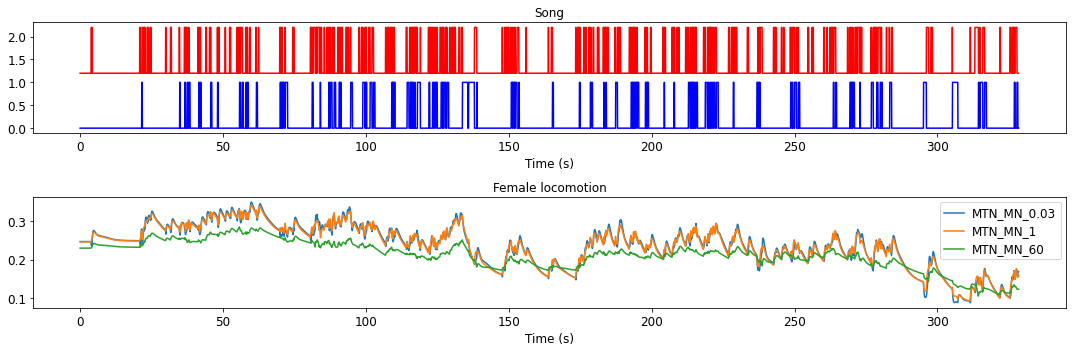

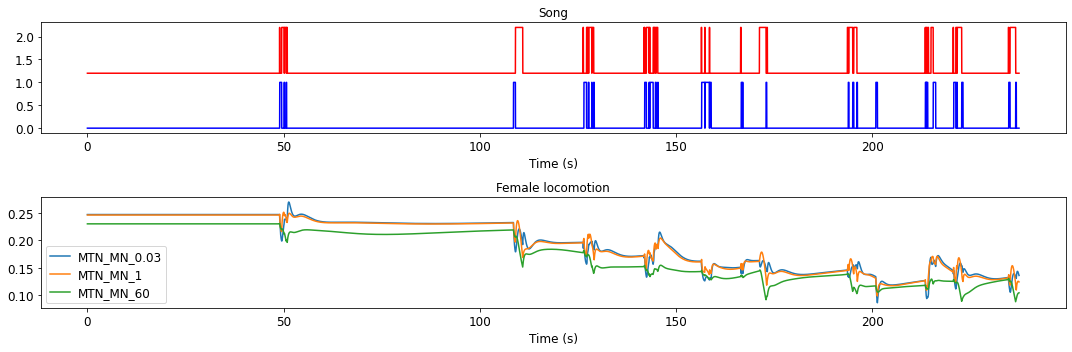

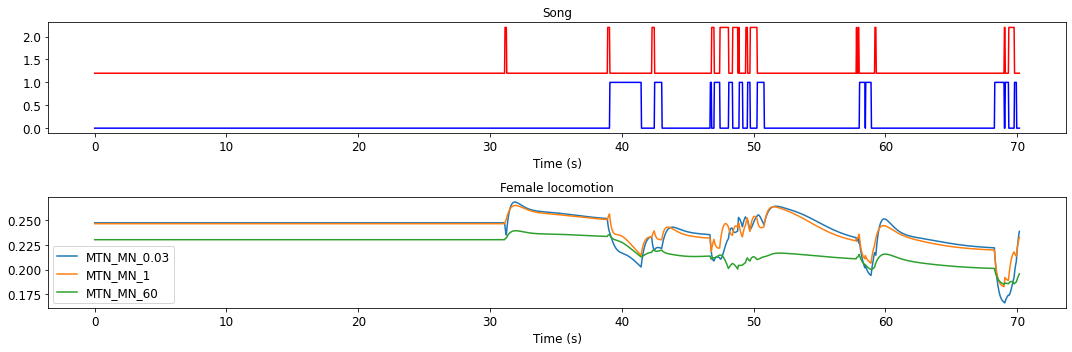

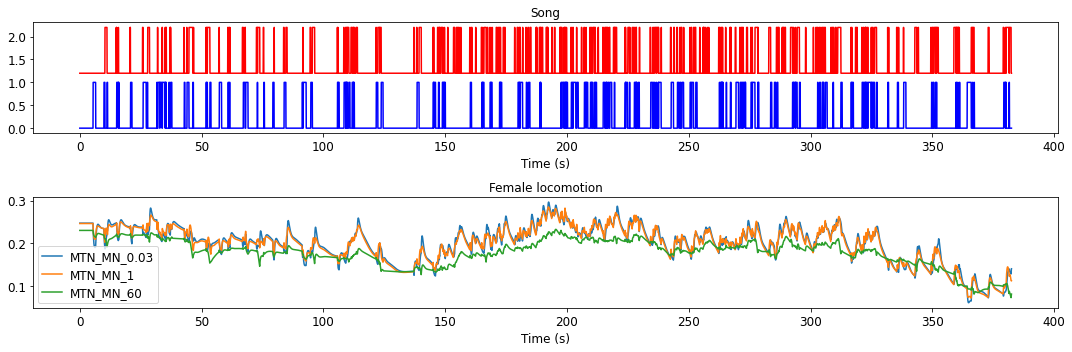

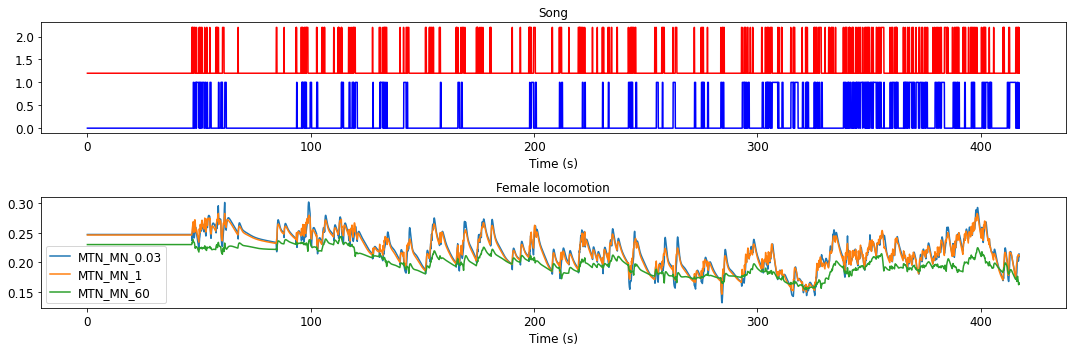

In [9]:
for ctr, df_tr_ma in enumerate(df_tr_mas[:5]):
    fig, axs = plt.subplots(2, 1, figsize=(15, 5), tight_layout=True)
    t = df_tr_ma['T']
    axs[0].plot(t, df_tr_ma['S'], c='b')
    axs[0].plot(t, df_tr_ma['P'] + 1.2, c='r')
    axs[0].set_title('Song')
    
    for targ in TARGS:
        axs[1].plot(t, df_tr_ma[targ])
        
    axs[1].set_title('Female locomotion')
    axs[1].legend(TARGS)
    
    for ax in axs:
        set_plot(ax, x_label='Time (s)', font_size=12)